In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np

In [2]:
dataset = pd.read_csv('dataset.csv')
print(dataset.head(10))

                                                Text  language
0  klement gottwaldi surnukeha palsameeriti ning ...  Estonian
1  sebes joseph pereira thomas  på eng the jesuit...   Swedish
2  ถนนเจริญกรุง อักษรโรมัน thanon charoen krung เ...      Thai
3  விசாகப்பட்டினம் தமிழ்ச்சங்கத்தை இந்துப் பத்திர...     Tamil
4  de spons behoort tot het geslacht haliclona en...     Dutch
5  エノが行きがかりでバスに乗ってしまい、気分が悪くなった際に助けるが、今すぐバスを降りたいと運...  Japanese
6  tsutinalar i̇ngilizce tsuutina kanadada albert...   Turkish
7  müller mox figura centralis circulorum doctoru...     Latin
8  برقی بار electric charge تمام زیرجوہری ذرات کی...      Urdu
9  シャーリー・フィールドは、サン・ベルナルド・アベニュー沿い市民センターとrtマーティン高校に...  Japanese


In [3]:
# Train / test split
breakpoint = int(0.8 * len(dataset))
train_x = dataset['Text'][:breakpoint]
test_x = dataset['Text'][breakpoint:]

# We will separate the ys later
ys = dataset['language']

# Free up some memory
del(dataset)

In [4]:
# Some hyperparameters
vocab_size = 40000
embedding_dim = 64
max_length = 150
trunc_type ='post'
oov_tok = '<OOV>'
num_unique_languages = len(set(ys))

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Create the vocabulary and convert sentences to sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(train_x)
word_index = tokenizer.word_index
training_sequences = tokenizer.texts_to_sequences(train_x)
training_padded = pad_sequences(training_sequences, maxlen = max_length)

test_sequences = tokenizer.texts_to_sequences(test_x)
test_padded = pad_sequences(test_sequences, maxlen = max_length)

# Tokenize labels too

label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(ys)
word_index_y = label_tokenizer.word_index
label_sequences = label_tokenizer.texts_to_sequences(ys)
label_padded = pad_sequences(label_sequences) # probably not necessary, as no language is 2 words long? oh well

In [14]:
# Converting to numpy arrays
training_padded = np.array(training_padded)
test_padded = np.array(test_padded)

# Now separate labels
training_ys = np.squeeze(np.array(label_padded[:breakpoint]))
test_ys = np.squeeze(np.array(label_padded[breakpoint:]))

# Problem: label tokenizer set range from 1 to num_unique_classes. Need range form 0 to num_unique_classes-1.
training_ys = training_ys - 1
test_ys = test_ys - 1
# Also fix the word index y dictionary
final_y_index = dict()
for language, value in word_index_y.items():
    final_y_index[language] = value - 1
word_index_y = final_y_index
del(final_y_index)

# one hot encode the ys as well
training_ys = tf.keras.utils.to_categorical(training_ys, num_classes=num_unique_languages)
test_ys = tf.keras.utils.to_categorical(test_ys, num_classes=num_unique_languages)

In [15]:
# Let's make the model
import tensorflow.keras.layers as layers
model = tf.keras.Sequential([
    layers.Embedding(vocab_size, embedding_dim, input_length=max_length), # hyperparameters set above
    layers.GlobalAveragePooling1D(),
    layers.Dense(32, activation='relu'),
    layers.Dense(num_unique_languages, activation='sigmoid')
])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 64)           2560000   
_________________________________________________________________
global_average_pooling1d_1 ( (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 22)                726       
Total params: 2,562,806
Trainable params: 2,562,806
Non-trainable params: 0
_________________________________________________________________


In [16]:
num_epochs = 25
history = model.fit(training_padded, training_ys, epochs=num_epochs, validation_data=(test_padded, test_ys), verbose=2)

Epoch 1/25
550/550 - 17s - loss: 2.3514 - accuracy: 0.4084 - val_loss: 1.2871 - val_accuracy: 0.7611
Epoch 2/25
550/550 - 17s - loss: 0.8581 - accuracy: 0.8341 - val_loss: 0.6401 - val_accuracy: 0.8643
Epoch 3/25
550/550 - 17s - loss: 0.4748 - accuracy: 0.8917 - val_loss: 0.4356 - val_accuracy: 0.9068
Epoch 4/25
550/550 - 17s - loss: 0.3340 - accuracy: 0.9077 - val_loss: 0.3500 - val_accuracy: 0.9070
Epoch 5/25
550/550 - 19s - loss: 0.2637 - accuracy: 0.9168 - val_loss: 0.2960 - val_accuracy: 0.9148
Epoch 6/25
550/550 - 18s - loss: 0.2212 - accuracy: 0.9247 - val_loss: 0.2634 - val_accuracy: 0.9173
Epoch 7/25
550/550 - 17s - loss: 0.1934 - accuracy: 0.9279 - val_loss: 0.2435 - val_accuracy: 0.9218
Epoch 8/25
550/550 - 17s - loss: 0.1725 - accuracy: 0.9314 - val_loss: 0.2306 - val_accuracy: 0.9239
Epoch 9/25
550/550 - 17s - loss: 0.1582 - accuracy: 0.9355 - val_loss: 0.2141 - val_accuracy: 0.9250
Epoch 10/25
550/550 - 17s - loss: 0.1454 - accuracy: 0.9369 - val_loss: 0.2145 - val_accura

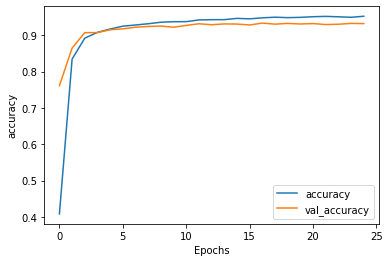

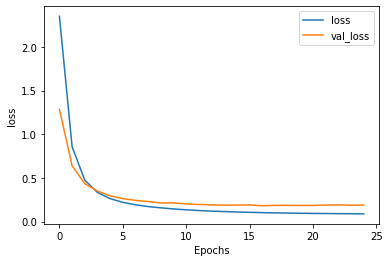

In [17]:
import matplotlib.pyplot as plt

# Some nice plots!

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [43]:
# Let's make a predict function
def predict(text, tokenizer, index_to_word_y, max_length, trunc_type):
    sequences = tokenizer.texts_to_sequences(text)
    padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)
    predictions = model.predict(padded)
    for prediction in predictions:
        most_likely_lang = np.argmax(prediction)
        print(index_to_word_y[most_likely_lang])

In [54]:
sentence = ['Pedro Sánchez Pérez-Castejón (Madrid, 29 de febrero de 1972) es un político español, actual presidente del Gobierno de España.', 
            'Hallo Hans. Wie geht es heute? Hast du Mittagessen gegessen?', # The model doesn't know German exists!
            'Emmanuel Macron, né le 21 décembre 1977 à Amiens, est un haut fonctionnaire, banquier d\'affaires et homme d\'État français. Il est président de la République française depuis le 14 mai 2017. ',
            'กรุงเทพมหานคร เป็นเมืองหลวงและนครที่มีประชากรมากที่สุดของประเทศไทย เป็นศูนย์กลางการปกครอง การศึกษา การคมนาคมขนส่ง การเงินการธนาคาร การพาณิชย์ การสื่อสาร และความเจริญของประเทศ ตั้งอยู่บนสามเหลี่ยมปากแม่น้ำเจ้าพระยา มีแม่น้ำเจ้าพระยาไหลผ่านและแบ่งเมืองออกเป็น 2 ฝั่ง คือ ฝั่งพระนครและฝั่งธนบุรี กรุงเทพมหานครมีพื้นที่ทั้งหมด 1,568.737 ตร.กม.',
            '你好!',
            'Gallia  est  omnis  dīvīsa  in  partēs  trēs,  quārum ūnam  incolunt  Belgae,  aliam Aquītānī,  tertiam  quī  ipsōrum  linguā  Celtae,nostrā  Gallī  appellantur.  '
           ]
index_to_word_y = dict([(value, key) for (key,value) in word_index_y.items()])
predict(sentence, tokenizer, index_to_word_y, max_length, trunc_type)

spanish
chinese
french
thai
chinese
latin


In [ ]:
# I used a Kaggle dataset for this project, which you can find here:
# https://www.kaggle.com/zarajamshaid/language-identification-datasst